# Analysis of students' grades performance based on multiple features

_Practice multiple linear and polynomial regression with a grades dataset, including multiple features to find correlations in the data_


## Introduction

High school students are definitely a mixture of new experiences, friends, and objectives for the future. This is why, in general, teenagers at this age start going through a phase in which a lot of decisions can be taken that will mark how the develop professionally in the future. Acknowledging the multiple characteristics that surround teens, the objective of the following analysis is to determine different factors that might have an impact on their grades, which, in consequence, can have an impact in their transition into the adult world.

The objective will be to take multiple features and construct a regression model optimized with multiple gradient descent in order to predict a student's grades based on different factors, as well as obtaining the features with the most correlation with a student's grades.

In the end, based on the analysis results, different strategies can be taken in order to improve the academic performance of students by promoting and discouraging certain conducts that encompass their lives.


## Data Loading

The dataset was obtained from Kaggle through:

https://www.kaggle.com/datasets/dillonmyrick/high-school-student-performance-and-demographics/data

This data can be imported from the .csv file using Pandas

In order to clean the data we make sure that we don't have missing values for the `student_id`, which identifies a new record. Using this same field we can check for duplicated entries and remove them. After doing so, because the analysis is anonymized, we can drop the student_id as it will have no impact on the results and is unnecessary.


In [1]:
import pandas as pd

# Import dataset from csv
df = pd.read_csv('./student_math_clean.csv')

# Get size
m = df.shape[0]
n = df.shape[1]

# Remove duplicates from dataset
df = df.drop_duplicates(subset=['student_id'])

# Show information
print(f"Missing values:\n{df['student_id'].isnull().sum()}")
print(f"Duplicates removed:\n{m - df.shape[0]}")
print(f"Dataset size:\nm = {m}\tn = {n}")
print(f"{df.columns}")

# Drop `student_id` column
df = df.drop(columns='student_id')

Missing values:
0
Duplicates removed:
0
Dataset size:
m = 395	n = 34
Index(['student_id', 'school', 'sex', 'age', 'address_type', 'family_size',
       'parent_status', 'mother_education', 'father_education', 'mother_job',
       'father_job', 'school_choice_reason', 'guardian', 'travel_time',
       'study_time', 'class_failures', 'school_support', 'family_support',
       'extra_paid_classes', 'activities', 'nursery_school', 'higher_ed',
       'internet_access', 'romantic_relationship', 'family_relationship',
       'free_time', 'social', 'weekday_alcohol', 'weekend_alcohol', 'health',
       'absences', 'grade_1', 'grade_2', 'final_grade'],
      dtype='object')


where $m$ is the number of training examples and $n$ is the number of columns in the data.


## Data Preprocessing

First, let's remove the target variable from the dataset and save it as a separate DataFrame so that we can manipulate the features separately


In [2]:
import numpy as np
y = df['final_grade']
X = df.drop(columns='final_grade')

In order to correctly process each column of the dataset, we have to divide it according to the datatype it contains


In [3]:
X.dtypes.unique()

array([dtype('O'), dtype('int64')], dtype=object)

As shown above, the dataframe contains `object` (string), `int`, and `None` types.

First, let's review the qualitative data shown by the `object` type items


In [4]:
def getUnique(df_in, dtype=None):
    # If data type not specified, get unique value for all columns
    # If data type specified, only get dtype columns
    if dtype: df_in = df_in.select_dtypes(include=dtype)

    # Assign all unique and non-Nan values into a dictionary
    # key : column
    # value : list of unique values
    dict_uv = {}
    for col in df_in.columns:
        dict_uv[col] = pd.Series(df_in[col].dropna().unique())

    # Convert to Pandas DataFrame
    df_uv = pd.DataFrame(data = dict_uv)

    # Replace NaN values according to dtype
    for col in df_uv.columns:
        default = np.nan if df_uv[col].dtype in [int, float] else ""
        df_uv[col] = df_uv[col].fillna(default)

    # Return DataFrame
    return df_uv

pd.set_option('display.max_columns', None)
getUnique(X, 'object')

,school,sex,address_type,family_size,parent_status,mother_education,father_education,mother_job,father_job,school_choice_reason,guardian,travel_time,study_time,school_support,family_support,extra_paid_classes,activities,nursery_school,higher_ed,internet_access,romantic_relationship
0,GP,F,Urban,Greater than 3,Apart,higher education,higher education,at_home,teacher,course,mother,15 to 30 min.,2 to 5 hours,yes,no,no,no,yes,yes,no,no
1,MS,M,Rural,Less than or equal to 3,Living together,primary education (4th grade),primary education (4th grade),health,other,other,father,<15 min.,5 to 10 hours,no,yes,yes,yes,no,no,yes,yes
2,,,,,,secondary education,5th to 9th grade,other,services,home,other,30 min. to 1 hour,<2 hours,,,,,,,,
3,,,,,,5th to 9th grade,secondary education,services,health,reputation,,>1 hour,>10 hours,,,,,,,,
4,,,,,,none,none,teacher,at_home,,,,,,,,,,,,


As seen above, some of the labels used to describe qualities such as `mother_education` and `father_education` are too big to be represented in a plot and could be abbreviated into smaller forms. Additionally, some values can be changed to binary from their assigned string equivalents, such as the values "yes" and "no" in `internet_access`, `higher_ed`, and `activities`.


In [5]:
X.replace({
    "Greater than 3" : ">3",
    "Less than or equal to 3" : "<=3",
    "Living together" : "Together",
    "primary education (4th grade)" : "<=4th",
    "5th to 9th grade" : "<=9th",
    "secondary education" : "<=12th",
    "higher education" : ">12th",
    "reputation" : "rep.",
    "<15 min." : "<15",
    "15 to 30 min." : "15-30",
    "30 min. to 1 hour" : "30-60",
    ">1 hour" : ">60",
    "<2 hours" : "<2",
    "2 to 5 hours" : "2-5",
    "5 to 10 hours" : "5-10",
    ">10 hours" : ">10",
    "yes" : 1,
    "no" : 0
}, inplace=True)

getUnique(X, 'object')

,school,sex,address_type,family_size,parent_status,mother_education,father_education,mother_job,father_job,school_choice_reason,guardian,travel_time,study_time
0,GP,F,Urban,>3,Apart,>12th,>12th,at_home,teacher,course,mother,15-30,2-5
1,MS,M,Rural,<=3,Together,<=4th,<=4th,health,other,other,father,<15,5-10
2,,,,,,<=12th,<=9th,other,services,home,other,30-60,<2
3,,,,,,<=9th,<=12th,services,health,rep.,,>60,>10
4,,,,,,none,none,teacher,at_home,,,,


Sadly, the most important thing is that, even with descriptive and small qualitative labels, in order to correctly fit a regression model over this type of information we must **assign numeric values** so that the weights that are formulated in the modelling section can **have an impact over each state of each feature**.

There are multiple ways to perform the encoding of categorical data into numerical data depending if the data is ordinal (can be ordered) or nominal (unordered / unrelated)


### Ordinal Encoding

This type of encoding uses fields that can be ordered by some type of quality or order of importance inherent to the specific feature. These different values can be represented with natural numbers according to their importance (like an index).

However, even if the values can be ordered, it doesn't mean they necessarily increase in hierarchy in a constant way. For example, with labels: `['trash', 'very bad', 'bad', 'meh', 'great', 'excellent']` mapped to `[1, 2, 3, 4, 5, 6]`, we can tell there is a bias to remain in negative scoring rather than in positive because of the increasing hierarchy of categories is not constant. To solve the latter, it is possible to collapse states into broader categories which can level this property out, like mapping `[1, 2, 3, 4]` to `0` for bad, and `[5, 6]` to `1` for good.

In our dataset, the fields that can be ordered are the education level of the parents and the time measurements. Apart from these fields, the other ones can be better engineered through other encoding methods.

The scikit-learn preprocessing module contains methods in order to automate the process of encoding the desired columns inside our dataset. To perform ordinal encoding we must provide the correct order or priority of each category of each column.


In [6]:
# Collapsing education categories into broader ones
edu_broad = {
    '<=4th' : 'Low',
    '<=9th' : 'Low',
    '<=12th' : 'Medium',
    '>12th' : 'High'
}
X.replace(edu_broad, inplace=True)

# Dictionary with each column's category order
col_order = {
    'mother_education' : ['none', 'Low', 'Medium', 'High'],
    'father_education' : ['none', 'Low', 'Medium', 'High'],
    'travel_time': ['<15', '15-30', '30-60', '>60'],
    'study_time': ['<2', '2-5', '5-10', '>10']
}

# Ordinal encoding
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=list(col_order.values()))
cols_oe = ['mother_education', 'father_education', 'travel_time', 'study_time']
# Convert numpy 2D array returned value into pandas DataFrame with column labels
df_oe = pd.DataFrame(enc.fit_transform(X[cols_oe]), columns=cols_oe)

getUnique(df_oe)

,mother_education,father_education,travel_time,study_time
0,3.0,3.0,1.0,1.0
1,1.0,1.0,0.0,2.0
2,2.0,2.0,2.0,0.0
3,0.0,0.0,3.0,3.0


### One-Hot Encoding

Contrary to the last type of encoding, this one is useful for data that cannot be ordered based on some hierarchy. It basically converts each category into a separate binary type column by itself. This means that we add a feature for each unique category in the column to encode and specify whether that feature is present for the specific training example.

For example, if we had a column `colors` with unique values `green` and `blue`, by one-hot encoding we would replace the `color` column with two extra columns called `color.green` and `color.blue`, each with a binary value.

The fields that should be encoded this way in our dataset are the parent's jobs, the school choice reason and the guardian. For fields that only contain two categories, another encoding method can be applied.

The scikit-learn preprocessing module also contains a one-hot encoding method to complete this process.


In [7]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder() 
cols_ohe = ['father_job', 'mother_job', 'school_choice_reason', 'guardian']
np_ohe = enc.fit_transform(X[cols_ohe]).toarray()
# Update the columns to column_category
cols_ohe_new = enc.get_feature_names_out()
# Convert numpy 2D array returned value into pandas DataFrame with column labels
df_ohe = pd.DataFrame(np_ohe, columns=cols_ohe_new)

getUnique(df_ohe)

,father_job_at_home,father_job_health,father_job_other,father_job_services,father_job_teacher,mother_job_at_home,mother_job_health,mother_job_other,mother_job_services,mother_job_teacher,school_choice_reason_course,school_choice_reason_home,school_choice_reason_other,school_choice_reason_rep.,guardian_father,guardian_mother,guardian_other
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


### Binary Encoding

Similar to One-Hot encoding, it can be used with unordered data. However, it should only be used for fields that have exactly 2 categories. Through this type of encoding we can collapse both categories into one of the two and assign it a binary value representing whether the training example is or not contained within that category.

For example, with a field `fav_pet` with categories `dog` and `cat`, by performing binary encoding we can replace the field which one of the two categories so that the entire column represents a single category, such as `fav_pet_dog`. If the binary value for the column is `1`, then the example is contained in `dog`, if the value is `0`, then the value is contained in `cat`.

In other words, it is like One-hot encoding but we drop one of the two resulting tables because of redundancy.


In [8]:
enc = OneHotEncoder(drop='first')
cols_be = ['school', 'sex', 'address_type', 'family_size', 'parent_status']
np_be = enc.fit_transform(X[cols_be]).toarray()
# Update the columns to column_category
cols_be_new = enc.get_feature_names_out()
# Convert numpy 2D array returned value into pandas DataFrame with column labels
df_be = pd.DataFrame(np_be, columns=cols_be_new)

getUnique(df_be)

,school_MS,sex_M,address_type_Urban,family_size_>3,parent_status_Together
0,0.0,0.0,1.0,1.0,0.0
1,1.0,1.0,0.0,0.0,1.0


Once the categorical data has been converted we can replace it into the original DataFrame


In [9]:
cols = cols_oe + cols_ohe + cols_be
X.drop(columns=cols, inplace=True)
for df_i in [df_oe, df_ohe, df_be]:
    X = X.join(df_i, how='inner')

# Sort the dataframe by column label in alphabetic order
X = X.sort_index(axis=1)

# pd.set_option('display.max_columns', 20)
getUnique(df).head(6)

,school,sex,age,address_type,family_size,parent_status,mother_education,father_education,mother_job,father_job,school_choice_reason,guardian,travel_time,study_time,class_failures,school_support,family_support,extra_paid_classes,activities,nursery_school,higher_ed,internet_access,romantic_relationship,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
0,GP,F,18.0,Urban,Greater than 3,Apart,higher education,higher education,at_home,teacher,course,mother,15 to 30 min.,2 to 5 hours,0.0,yes,no,no,no,yes,yes,no,no,4.0,3.0,4.0,1.0,1.0,3.0,6,5.0,6.0,6.0
1,MS,M,17.0,Rural,Less than or equal to 3,Living together,primary education (4th grade),primary education (4th grade),health,other,other,father,<15 min.,5 to 10 hours,3.0,no,yes,yes,yes,no,no,yes,yes,5.0,2.0,3.0,2.0,3.0,5.0,4,7.0,5.0,10.0
2,,,15.0,,,,secondary education,5th to 9th grade,other,services,home,other,30 min. to 1 hour,<2 hours,2.0,,,,,,,,,3.0,4.0,2.0,5.0,2.0,1.0,10,15.0,8.0,15.0
3,,,16.0,,,,5th to 9th grade,secondary education,services,health,reputation,,>1 hour,>10 hours,1.0,,,,,,,,,1.0,1.0,1.0,3.0,4.0,2.0,2,6.0,14.0,11.0
4,,,19.0,,,,none,none,teacher,at_home,,,,,NaN,,,,,,,,,2.0,5.0,5.0,4.0,5.0,4.0,0,12.0,10.0,19.0
5,,,22.0,,,,,,,,,,,,NaN,,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,16,16.0,15.0,9.0


Now that all our features are numerical, we can analyze them and perform feature scaling, normalization or standardization as needed.


## Feature Engineering

A simple feature engineering involves scaling, normalizing, and/or standardizing the entire preprocessed dataset.

In order to do so, we can first observe the range of the values of each column in the dataset.


In [10]:
X_info = pd.DataFrame([X.min(), X.max(), np.ptp(X, axis=0)], index=['min', 'max', 'range'])
# Sort by range value in descending order
X_info = X_info.sort_values(by="range", ascending=False, axis=1)
# Displaying only the highest ranges to avoid displaying the binary-value columns
X_info.iloc[:, :10]

,absences,grade_2,grade_1,age,free_time,weekday_alcohol,social,health,weekend_alcohol,family_relationship
min,0.0,0.0,3.0,15.0,1.0,1.0,1.0,1.0,1.0,1.0
max,75.0,19.0,19.0,22.0,5.0,5.0,5.0,5.0,5.0,5.0
range,75.0,19.0,16.0,7.0,4.0,4.0,4.0,4.0,4.0,4.0


It is clear that the range of the minimum and maximum values of different features are really far apart and extend more in some than in others. For example, fields such as `free_time`, `social`, and `health` only range from 1 to 5 according to the qualitative information provided by the student, ranging from 1 for very low to 5 for very high. Other features span a greater amount of ranges and not just groups, such as `absences`, from 0 to 75, and `final_grade`, from 0 to 20.

The previous statement justifies the need for feature engineering and feature scaling on all numerical features in order to optimize the gradient descent algorithm.

The feature scaling that will be applied to the the dataset will be the **Z-Score Normalization**, which is also referred to as Standardization. The basic formula to apply it is:

$$
\begin{align}
Z_j^{(i)} = \frac{X_j^{(i)}-\mu_j}{\sigma_j^{(i)}}
\end{align}
$$

This modification to the features will make the linear or polynomial regression algorithm return coefficients that can be interpreted with more ease in order to identify which features have the most correlation with the target variable. Each coefficient will represent the change in the target in terms of the standard deviation of each feature.

To perform the standardization we can use the scikit-learn preprocessing module


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Save columns 
cols = X.columns
# Fit to get mean and std. dev., transform features and convert to pandas DataFrame
X = pd.DataFrame(scaler.fit_transform(X), columns=cols)

After performing the standardization we can plot all of the features along with a distribution plot to confirm that the feature setting was successful and to begin observing the different relationships in the data.


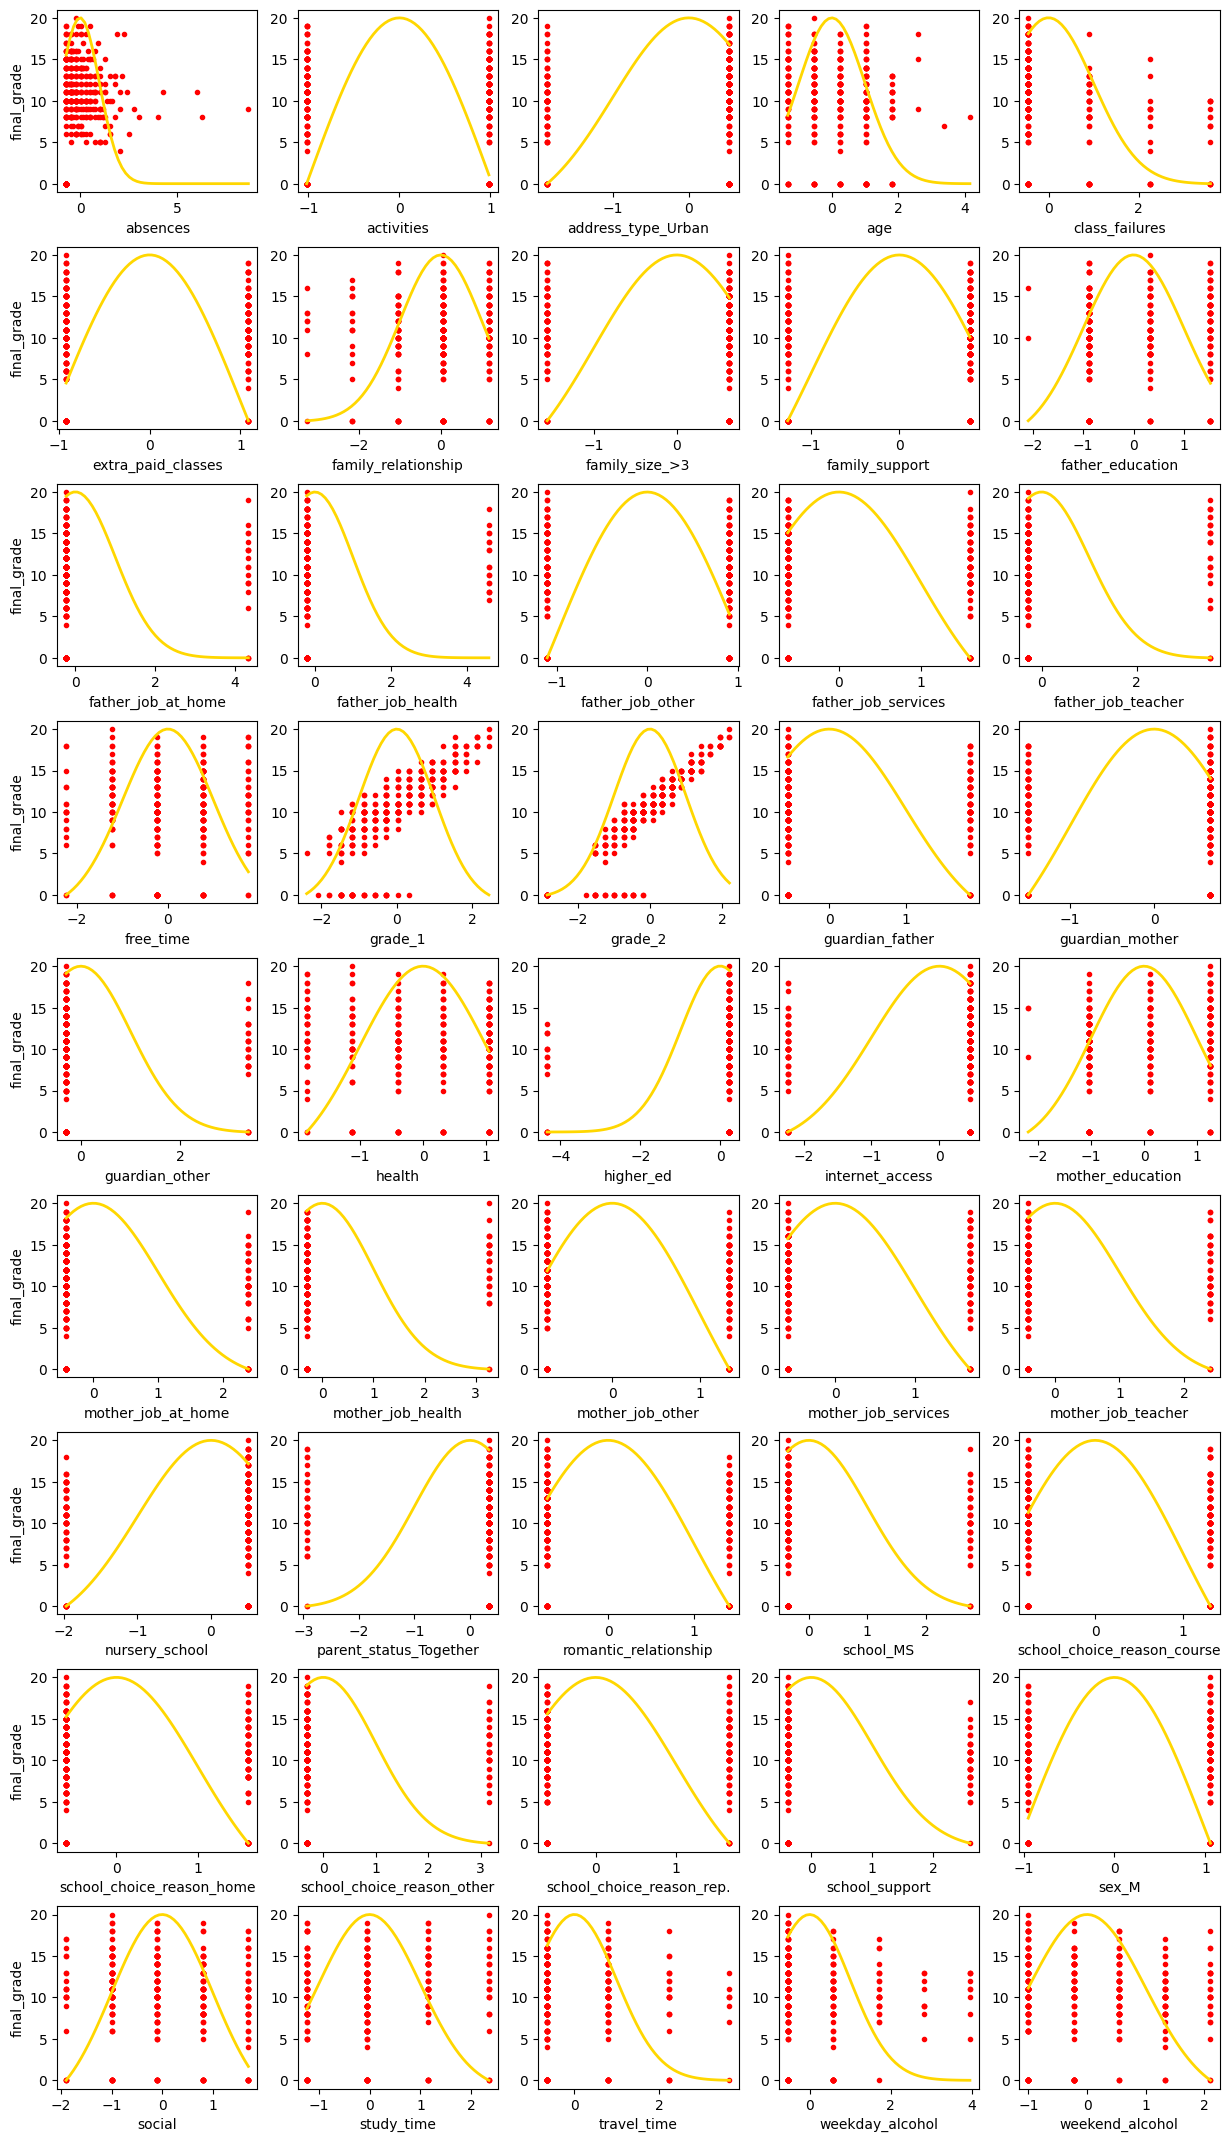

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

# Number of columns per row to show
n_cols = 5

# Function to plot the probability density function
def plotDistribution(x, ax):
    # Create a twin ax array to display a second y-axis on the same space
    axr = ax.twinx()
    axr.axis('off')
    # Numpy array of means and std. deviations
    mu = np.mean(x)
    std = np.std(x)
    # Create x values for the distribution plot
    dist_x = np.linspace(np.min(x), np.max(x), 50)
    # Compute distribution through probability density function
    dist_y = norm.pdf(dist_x, loc=mu, scale = std)
    # Plot on axis
    axr.plot(dist_x, dist_y, color = 'gold', lw=2)


def plotFeatures(X, y, n_cols=4):
    n = len(X.columns)
    n_rows = math.ceil(n/n_cols)

    # Prepare labels to select x and y arrays for plotting
    features = X.columns
    target = y.name
    n_plotted = 0  

    # Create the subplots and assign to each axis a plot of feature_i vs final_grade
    fig,ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), gridspec_kw={'hspace':0.3})
    for row in range(n_rows):
        for col in range(n_cols):
            if (n_plotted < n):
                i = n_cols*row + col
                ax[row, col].scatter(X[features[i]], y, marker='.', c='r')
                ax[row, col].set_xlabel(features[i])
                plotDistribution(X[features[i]], ax[row, col])
                if col == 0:
                    ax[row, col].set_ylabel(target)
                n_plotted += 1
    # fig.suptitle("Distribution of features before normalization")


plotFeatures(X, y, n_cols)

After performing the standardization, the unique values are different of the standard deviation to the mean value


In [13]:
getUnique(X).head(5)

,absences,activities,address_type_Urban,age,class_failures,extra_paid_classes,family_relationship,family_size_>3,family_support,father_education,father_job_at_home,father_job_health,father_job_other,father_job_services,father_job_teacher,free_time,grade_1,grade_2,guardian_father,guardian_mother,guardian_other,health,higher_ed,internet_access,mother_education,mother_job_at_home,mother_job_health,mother_job_other,mother_job_services,mother_job_teacher,nursery_school,parent_status_Together,romantic_relationship,school_MS,school_choice_reason_course,school_choice_reason_home,school_choice_reason_other,school_choice_reason_rep.,school_support,sex_M,social,study_time,travel_time,weekday_alcohol,weekend_alcohol
0,0.036424,-1.017881,0.535392,1.023046,-0.449944,-0.919671,0.062194,0.636941,-1.257656,1.522368,-0.230940,-0.218507,-1.104129,-0.625176,3.552561,-0.236010,-1.782467,-1.254791,-0.543214,0.668496,-0.296908,-0.399289,0.230940,-2.232677,1.251748,2.386402,-0.306892,-0.745062,-0.593919,-0.414858,0.507899,-2.938392,-0.708450,-0.363050,1.313064,-0.617348,-0.316668,-0.601722,2.597133,-0.948176,0.801479,-0.042286,0.792251,-0.540699,-1.003789
1,-0.213796,0.982433,-1.867789,0.238380,3.589323,1.087346,1.178860,-1.570004,0.795130,-0.882973,4.330127,4.576510,0.905691,1.599549,-0.281487,-1.238419,-1.179147,-1.520979,1.840894,-1.495896,3.368048,1.041070,-4.330127,0.447893,-1.037328,-0.419041,3.258473,1.342169,1.683731,2.410466,-1.968894,0.340322,1.411533,2.754443,-0.761577,1.619831,3.157883,1.661898,-0.385040,1.054656,-0.097908,1.150779,-0.643249,0.583385,0.551100
2,0.536865,NaN,NaN,-1.330954,2.242901,NaN,-1.054472,NaN,NaN,0.319697,NaN,NaN,NaN,NaN,NaN,0.766399,1.234133,-0.722415,NaN,NaN,NaN,-1.839649,NaN,NaN,0.107210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.997295,-1.235351,2.227751,3.955638,-0.226345
3,-0.464016,NaN,NaN,-0.546287,0.896479,NaN,-3.287804,NaN,NaN,-2.085644,NaN,NaN,NaN,NaN,NaN,-2.240828,-1.480807,0.874715,NaN,NaN,NaN,-1.119469,NaN,NaN,-2.181866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.896683,2.343844,3.663251,1.707469,1.328545
4,-0.714236,NaN,NaN,1.807713,NaN,NaN,-2.171138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.768808,0.329153,-0.190038,NaN,NaN,NaN,0.320890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.700867,NaN,NaN,2.831553,2.105989


## Data Selection

From the $n$ features, most provide relevant information to train models.

In order to perform the analysis with multiple perspectives, regression models based on different amount and specific features will be created. Each will have the purpose of observing the impact of the following areas around a teen's life on their final grades:

- Parents, home and family
  - `mother_education`
  - `father_education`
  - `parent_status`
  - `internet_access`
  - `address_type`
  - `family_relationship`
- Student's traits and aspirations
  - `age`
  - `sex`
  - `health`
  - `social`
  - `higher_ed`
  - `school_choice_reason`
- Time management
  - `travel_time`
  - `study_time`
  - `free_time`
  - `activities`
  - `absences`
- All-round perspective
  - All of the above

The target value will be the `final_grade` of each student on the course.

In order to delimit the dataframe we can create multiple ones according with each model's training features.


In [14]:
X_home = X[['mother_education', 'father_education', 'parent_status_Together', 'internet_access', 'address_type_Urban', 'family_relationship']]
X_stud = X[['age', 'sex_M', 'health', 'social', 'higher_ed', 'school_choice_reason_course', 'school_choice_reason_home',	'school_choice_reason_other', 'school_choice_reason_rep.']]
X_time = X[['travel_time', 'study_time', 'free_time', 'activities', 'absences']]
X_all = X_home.join([X_stud, X_time])

print(f"Parents, home and family:\n  {X_home.columns}\n")
print(f"Student's traits and aspirations:\n  {X_stud.columns}\n")
print(f"Time management:\n  {X_time.columns}\n")
print(f"All-round perspective:\n  {X_all.columns}")

Parents, home and family:
  Index(['mother_education', 'father_education', 'parent_status_Together',
       'internet_access', 'address_type_Urban', 'family_relationship'],
      dtype='object')

Student's traits and aspirations:
  Index(['age', 'sex_M', 'health', 'social', 'higher_ed',
       'school_choice_reason_course', 'school_choice_reason_home',
       'school_choice_reason_other', 'school_choice_reason_rep.'],
      dtype='object')

Time management:
  Index(['travel_time', 'study_time', 'free_time', 'activities', 'absences'], dtype='object')

All-round perspective:
  Index(['mother_education', 'father_education', 'parent_status_Together',
       'internet_access', 'address_type_Urban', 'family_relationship', 'age',
       'sex_M', 'health', 'social', 'higher_ed', 'school_choice_reason_course',
       'school_choice_reason_home', 'school_choice_reason_other',
       'school_choice_reason_rep.', 'travel_time', 'study_time', 'free_time',
       'activities', 'absences'],
      dty

## Data Modeling

Once that all of the data has been correctly prepared, we can perform the multiple linear regression model for every different perspective defined above.

A multiple linear regression model creates a linear function consisting of multiple terms and an additional bias coefficient $b$. Each term corresponding to each feature of the model will have a weight $w_j$ assigned to it. This weight represents the correlation of that feature $x_j$ with the estimation $\hat{y}$. If $w_j$ is negative, $\hat{y}$ will decrease as $x_j$ increases, and viceversa.

In order to find the weights and bias that fit the model as close as linearly possible to the population (real target) values, we use an optimization algorithm called gradient descent. The purpose of gradient descent is to minimize a the result of a given function by certain its parameters. In the context of linear regression, gradient descent is used to minimize the difference between our sample values or estimations and our population values or target. This difference is often also called the cost or error of the linear model.

When gradient descent is running, the algorithm gets optimized at a certain learning rate $\alpha$ and up to a certain precision $\epsilon$. As the weights and bias get closer to the minimum value possible for the model, the jumps, or learning rate, at which the model gets optimized is more and more important.

A smaller learning rate can be slower but can provide a lot more precision, and viceversa. When the learning rate is huge in comparison to the gradient (steepness of the learning rate at the iteration) we could generate a never ending loop. On the other hand, setting a small epsilon value will make the algorithm not stop until either it reaches the max_iter or the precision requirement is met.

First, we have to define $\alpha$ and $\epsilon$


In [15]:
alpha = 1e-4
epsilon = 1e-8

Through the scikit-learn.linear_model module we can perform the multiple linear regression model


### Parents, home and family


In [16]:
from sklearn.linear_model import SGDRegressor

sgdr = SGDRegressor(max_iter=10000, loss='squared_error', alpha=alpha, epsilon=epsilon)
sgdr.fit(X_home, y)
w = sgdr.coef_
b = sgdr.intercept_
print(f"X_home")
print(f"Number of iterations completed: {sgdr.n_iter_}\nNumber of weight updates: {sgdr.t_}")
print(f"Parameters:\n  w={w}\n  b={b}")

X_home
Number of iterations completed: 29
Number of weight updates: 11456.0
Parameters:
  w=[ 0.84157557  0.05781031 -0.19239921  0.24158832  0.31128402  0.24771963]
  b=[10.40173571]


## Results


## Conclusion


## References
